# Problem 1

> Describe the main components of a typical enigma machine.

The main components of a typical enigma machine consisted of rotors, rings, keyboard, plugboard and reflector. The following is a description of each:

• Rotors
    o There is a total of 5 available but only 3 are used at a time.
    o Each rotor has an initial starting position and there are a total of 17,576 starting positions (263).
    o The ﬁrst rotor would step on the second rotor on each full iteration under the control of a ring hitting a notch. The second would step on the third after hitting the notch.
         Notch and ring positions were only important for first two rotors.

• Rings
    o Each ring can be placed in various positions.
    o The positions formed part of the key (k).
    o The total number of ring positions (for 2 rotors) was 676 (262).
         3 rotors = 26 · 25 · 26 = 16,900.

• Keyboard
    o This was a normal typewriter keyboard and each letter connected to the plugboard.

• Plugboard
    o This was used to swap letters twice in each encryption and decryption operation.
         Done to increase the complexity of possible keys.

    o The secret key comprised of:
         Rotor order
         Rotor starting position
         Ring position
         Plugboard settings
    o The total number of keys was then around 275
    
• Reflector
    o This was used to ensure the encryption and decryption process were using the same operation – symmetrical encryption.


# Problem 2

> What is the size of the key space?

# Problem 3

> Explain the flow of the code and map the settings to the components mentioned in Problem 1. 

# Problem 4

> Learning by testing. Test the code with at least 7 various keys (change of wiring, ring_setting, stepping, reflector, with or without plugboard, initial display position, etc.

In [ ]:
from __future__ import annotations
from typing import Optional, List, Tuple
import re
from enigma.rotors.rotor import Rotor
from enigma.plugboard import Plugboard
from enigma.machine import EnigmaMachine

"""
During the war, Enigma machine operators re-configured their machines every day according to a code book, or key sheet, to help increase security. Each key sheet contained daily Enigma settings for one month. Before transmitting the first message of the day, the operator looked up the current day on the key sheet for the given month nd configured the machine accordingly.
"""

"""
When calling the Rotor constructor directly, the internal wiring is specified as a 26-character long string which specifies the cipher substitution. This notation is consistent with several online sources of Enigma information

`wiring` this should be a string of 26 uppercase characters A-Z that represent the internal wiring transformation of the signal as it enters from the right side. This is the format used in various online resources. For example, for the Wehrmacht Enigma type I rotor the mapping is "EKMFLGDQVZNTOWYHXUSPAIBRCJ"

`ring_setting` arguments are 0-based integers (0-25). his should be an integer from 0-25, inclusive, which indicates the Ringstellung. A value of 0 means there is no offset; e.g. the letter A is fixed to pin 0. A value of 1 means B is mapped to pin 0

`stepping` arguments specify when rotors turn their neighbor. This is the stepping or turnover parameter. When it is an iterable, for example a string such as “Q”, this indicates that when the rotor transitions from “Q” to “R” (by observing the operator window), the rotor will “kick” the rotor to its left, causing it to rotate.

If the rotor has more than one notch, a string of length 2 could be used, e.g. “ZM”. Another
way to think of this parameter is that when a character in the stepping string is visible in
the operator window, a notch is lined up with the pawl on the left side of the rotor. This
will allow the pawl to push up on the rotor and the rotor to the left when the next key is
depressed. A value of None means this rotor does not rotate.
"""
rL = Rotor('my rotor1', 'EKMFLGDQVZNTOWYHXUSPAIBRCJ', ring_setting=0, stepping='Q')
rM = Rotor('my rotor2', 'BDFHJLCPRTXVZNYEIWGAKMUSQO', ring_setting=5, stepping='V')
rR = Rotor('my rotor3', 'ESOVPZJAYQUIRHXLNFTGKDCMWB', ring_setting=10, stepping='J')
default_rotors = [rL, rM, rR]
rotor_characters = set(*['EKMFLGDQVZNTOWYHXUSPAIBRCJ'])

assert(
    rotor_characters == set(*['BDFHJLCPRTXVZNYEIWGAKMUSQO'])
)

assert(
    rotor_characters == set(*['ESOVPZJAYQUIRHXLNFTGKDCMWB'])
)

"""
 Reflectors are simulated as rotors that have no ring setting or stepping capability
 If you decide to create your own reflector, and you desire to maintain reciprocal encryption & decryption (a fundamental characteristic of war-time Enigma machines), your connections must be made in pairs. Thus if you wire 'A' to 'G', you must also wire 'G' to 'A', and so on.
"""
default_reflector = Rotor('my reflector', 'YRUHQSLDPXNGOKMIEBFZCWVJAT')

assert(
    set(*['YRUHQSLDPXNGOKMIEBFZCWVJAT']) == rotor_characters
)

"""
The plugboard, or Steckerbrett in German, allows the operator to swap up to 10 keys and indicator lamps for increased key strength. Plugboards have little use on their own.
"""
default_plugboard = Plugboard.from_key_sheet('AK BZ CG DL FU HJ MX NR OY PW')

assert(
    set(*['AKBZCGDLFUHJMXNROYPW']).issubset(rotor_characters)
)

default_initial_rotor_position = 'UPS'

# Encrypt a letter
# print(machine.key_press('C'))
# Encrypt a text
# print(machine.process_text('Enigma machine is powerful for Q'))

MessageKey = str
EncryptionKey = str
CipherText = str
PlainText = str
EncryptionPayload = Tuple[EncryptionKey, CipherText]
DecryptionPayload = Tuple[MessageKey, PlainText]

three_uppercase_letters = re.compile(r'^[A-Z]{3}$')
is_three_uppercase_letters = lambda x: bool(three_uppercase_letters.search(x))

class WrappedEnigmaMachine(EnigmaMachine):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self._initial_rotor_position: Optional[str] = None

    @staticmethod
    def make_machine(
        rotors: Optional[List[Rotor]] = default_rotors,
        plugboard: Optional[Plugboard] = default_plugboard,
        reflector: Optional[Rotor] = default_reflector,
        initial_rotor_position: Optional[str] = default_initial_rotor_position
    ) -> WrappedEnigmaMachine:
            
        machine = WrappedEnigmaMachine(rotors, reflector, plugboard)

        if initial_rotor_position is not None:
            machine.set_display(initial_rotor_position)
            machine.initial_rotor_position = initial_rotor_position

        return machine
    
    @property
    def initial_rotor_position(self) -> Optional[str]:
        return self._initial_rotor_position

    @initial_rotor_position.setter
    def initial_rotor_position(self, value: Optional[str]):
        assert(is_three_uppercase_letters(value))
        self._initial_rotor_position = value

    def encrypt(self, payload: DecryptionPayload, rotor_position: Optional[str] = None) -> EncryptionPayload:
        if rotor_position is not None:
            assert(is_three_uppercase_letters(rotor_position))
            self.set_display(rotor_position)
        else:
            self.set_display(self.initial_rotor_position)

        message_key, plaintext = payload

        assert(is_three_uppercase_letters(message_key))

        enc_key =  self.process_text(message_key)

        self.set_display(message_key)
        ciphertext = self.process_text(plaintext)

        return (enc_key, ciphertext)

    def decrypt(self, payload: EncryptionPayload, rotor_position: Optional[str] = None) -> DecryptionPayload:
        if rotor_position is not None:
            assert(is_three_uppercase_letters(rotor_position))
            self.set_display(rotor_position)
        else:
            self.set_display(self.initial_rotor_position)

        enc_key, ciphertext = payload
        assert(is_three_uppercase_letters(enc_key))
        message_key = self.process_text(enc_key)

        assert(is_three_uppercase_letters(message_key))

        self.set_display(message_key)

        plaintext = self.process_text(ciphertext)
        return (message_key, plaintext)

machine = WrappedEnigmaMachine.make_machine()    

encrypted_payload = machine.encrypt(('ABC', 'ENIGMA'), 'DEF')
decrypted_payload = machine.decrypt(encrypted_payload, 'DEF')

assert(
    encrypted_payload == ('URP', 'CWGFDC')
)
assert(
    decrypted_payload == ('ABC', 'ENIGMA')
)

encrypted_payload = machine.encrypt(('ABC', 'ENIGMA'))
decrypted_payload = machine.decrypt(encrypted_payload)

assert(
    encrypted_payload == ('BDE', 'CWGFDC')
)
assert(
    decrypted_payload == ('ABC', 'ENIGMA')
)



# Problem 5

>  Pick one of the ciphertext and decrypt it. Do we need to write another code for that?

# Problem 6

> Time for fun. Same setting as given in the sample code, but folks at Bletchley Park want to know the initial position (display). They had a ciphertext “WVUVJCSQBFLWSGTHDREWOSXYIAYEUBHHXY” from known plaintext “ATTACK AT 5PM AT ATLANTIC Z ISLAND”. Code and find the init display.

With an initial display of `UPS`, we need a message key of `NYU` to end up with the same ciphertext.

In [4]:
from typing import Optional
from itertools import product
from string import ascii_uppercase

known_ciphertext = "WVUVJCSQBFLWSGTHDREWOSXYIAYEUBHHXY"
known_plaintext = "ATTACK AT 5PM AT ATLANTIC Z ISLAND"

initial_rotor_position: str = 'UPS'

assert(
    set(*[known_ciphertext]).issubset(rotor_characters)
)

machine = WrappedEnigmaMachine.make_machine(
    initial_rotor_position=initial_rotor_position
)

# Get the actual machine decrypted plaintext
_, machine_known_plaintext = machine.decrypt(machine.encrypt(('ABC', known_plaintext)))

def check_candidate(decrypted_payload: DecryptionPayload) -> None:
    message_key, plaintext = decrypted_payload

    assert(
        plaintext == machine_known_plaintext
    )

    enc_key, ciphertext = machine.encrypt((message_key, plaintext))

    assert(
        ciphertext == known_ciphertext
    )

    print(f'Will decrypt with message key "{message_key}" and initial rotor position "{initial_rotor_position}". {message_key} -> {enc_key}')

for enc_key in product(ascii_uppercase, repeat=3):
    decrypted_payload = machine.decrypt((''.join(enc_key), known_ciphertext))
    try:
        check_candidate(decrypted_payload)
    except AssertionError:
        pass


Will decrypt with message key "NYU" and initial rotor position "UPS". NYU -> DSM


# Problem 7

> (optional) Same enigma machine given by the sample code. We had the ciphertext   “YNLIUNHBNVERXKRBUHZEYMJVEZNRPNWOSV” from known plaintext “ATTACK AT 5PM AT ATLANTIC Z ISLAND”. Recover as much of the stecker settings as it possible from the known plaintext.


Keysheet 'HJ DL OY NR PW' is most likely with an overlap of 25 characters out of 34.

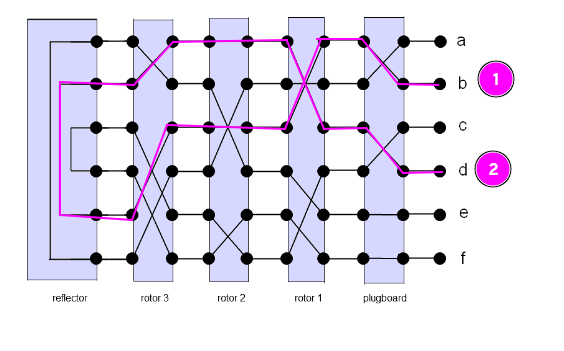

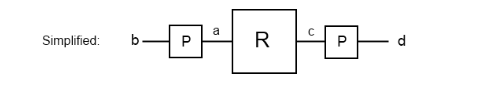

In [154]:
from itertools import combinations
from typing import Set, Tuple

known_ciphertext = "YNLIUNHBNVERXKRBUHZEYMJVEZNRPNWOSV"
known_plaintext = "ATTACK AT 5PM AT ATLANTIC Z ISLAND"

initial_rotor_position: str = 'UPS'

assert(
    set(*[known_ciphertext]).issubset(rotor_characters)
)

no_plugboard_machine = WrappedEnigmaMachine.make_machine(
    plugboard=Plugboard(),
    initial_rotor_position=initial_rotor_position
)

enc_key, no_plugboard_ciphertext = no_plugboard_machine.encrypt((initial_rotor_position, known_plaintext))
# no_plugboard_ciphertext = ORDIORHBRQZVXHNBUJZBOWHVNCRSWRWYGU
# known_ciphertext        = YNLIUNHBNVERXKRBUHZEYMJVEZNRPNWOSV
# We can begin to infer the plug board without knowing the exact key

plugboard_combinations: Set[Tuple[str,str]] = set()
for idx, c in enumerate(no_plugboard_ciphertext):
    if c != known_ciphertext[idx]:
        combo = sorted(list((c, known_ciphertext[idx])))
        plugboard_combinations.add((combo[0], combo[1]))

def has_overlap(guess):
    char_counts = {}
    for item in guess:
        (a,b) = item
        char_counts[a] = char_counts.get(a, 0) + 1
        char_counts[b] = char_counts.get(b, 0) + 1
        if char_counts[a] > 1 or char_counts[b] > 1:
            return True
    return False

guesses = []
for guess_count in range(10):
    for guess in combinations(plugboard_combinations, r=10 - guess_count):
        if has_overlap(guess):
            continue
        
        keysheet = ' '.join([f'{a}{b}' for (a,b) in guess])
        machine = WrappedEnigmaMachine.make_machine(
            initial_rotor_position=initial_rotor_position,
            plugboard=Plugboard.from_key_sheet(keysheet),
        )
        _, guess_ciphertext  = machine.encrypt((initial_rotor_position, known_plaintext))

        count = 0
        for idx, c in enumerate(guess_ciphertext):
            if c == known_ciphertext[idx]:
                count += 1

        guesses.append((count, keysheet, guess_ciphertext))

guesses = sorted(guesses, key=lambda x: x[0], reverse=True)
char_overlap, key_sheet, ciphertext = guesses[0]

print(
    f"Keysheet '{key_sheet}' is most likely with an overlap of {char_overlap} characters out of {len(known_ciphertext)}\n",
    f"the ciphertext is {ciphertext}"
)

Keysheet 'HJ DL OY NR PW' is most likely with an overlap of 25 characters out of 34
 the ciphertext is YNLIYNJBNQZRXJRBUHZEYXJVRCNSPNWOSV
